# Personal Info

Name: Seyyed Amirmahdi Sadrzadeh

Student Number: 401102015

# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

## Helper Functioins

In [4]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [5]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [6]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1404 has been set.
GPU is enabled in this notebook.


# Reminder and a sample of training loop

In [15]:
class emnist_net(nn.Module):


  """
  Neural network instance with following structure
  # Convolutional Layer 1: 1 --> 32, kernel_size=5, padding=2 + maxpooling
  # Convolutional Block 2: 32 --> 64, kernel_size=5, padding=2 + maxpooling
  # Fully Connected Layer 1: 3136 --> 128
  # Fully Connected Layer 2: 128 --> 2
  """


  def __init__(self):
    """
    Initialise parameters of sample network

    Args:
      None

    Returns:
      Nothing
    """
    super().__init__()

    ####################################################################
    # TODO:
    # 1) Define the required layers according to the given structure

    # comment the line below to test your code
    # raise NotImplementedError("Define the required layers")
    ####################################################################

    # 1)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1)
    self.fc1 = nn.Linear(1600, 128)  # After two max pools, image size is reduced from 28x28 to 7x7
    self.fc2 = nn.Linear(128, 26)


  def forward(self, x):
    """
    Forward pass of sample network

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through sample network
    """

    ####################################################################
    # TODO:
    # 2) Define forward pass for any input x (don't forget relus)

    # comment the line below to test your code
    # raise NotImplementedError("Define forward pass for any input x")
    ####################################################################

    # 2)

    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2) # another way to implement maxpooling

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = x = torch.flatten(x, 1)  # another way to flatten the output
    x = self.fc1(x)
    x = F.relu(x)

    # Fully connected layer 2.
    x = self.fc2(x)

    return x

In [11]:
# Download the data

fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

mnist_train = datasets.EMNIST(root=".",
                              train=True,
                              transform=transforms.ToTensor(),
                              download=False,
                              split='letters')
mnist_test = datasets.EMNIST(root=".",
                             train=False,
                             transform=transforms.ToTensor(),
                             download=False,
                             split='letters')

# Labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# Create data loaders
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,
                                           shuffle=False,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

EMNIST dataset has already been downloaded.



In [16]:
# Training

model = emnist_net().to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Iterate through train set minibatchs
for epoch in trange(3):
  for images, labels in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad()

    # Forward pass
    x = images

    # Move the data to GPU for faster execution
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    # Calculate loss
    loss = criterion(y, labs)

    # Backpropagation and gradient update
    loss.backward() # Calculate gradients
    optimizer.step() # Apply gradient udpate


# Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct / total * 100:.2f}%')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Test accuracy: 92.99%


# Download Fashion MNIST dataset

* The dataset we are going to use consists of a training set of 60,000 examples and a test set of 10,000 examples.Each example is a 28x28 gray scale image, associated with a label from 10 classes.

* Reducing the dataset to just the two categories (T-shirt/top and Shirt) reduces the training time to about 2 minutes.

In [18]:
import os
if os.path.exists("FashionMNIST.tar.gz"):
    os.remove("FashionMNIST.tar.gz")

In [19]:
# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)




Extracting the files...



In [20]:
# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing Fashion-MNIST Data to two-categories:
    T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

Visualize the data

In [21]:
#num_classes = 10
#train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

# Example of reducing the data into 2 categories
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 1404 has been set.


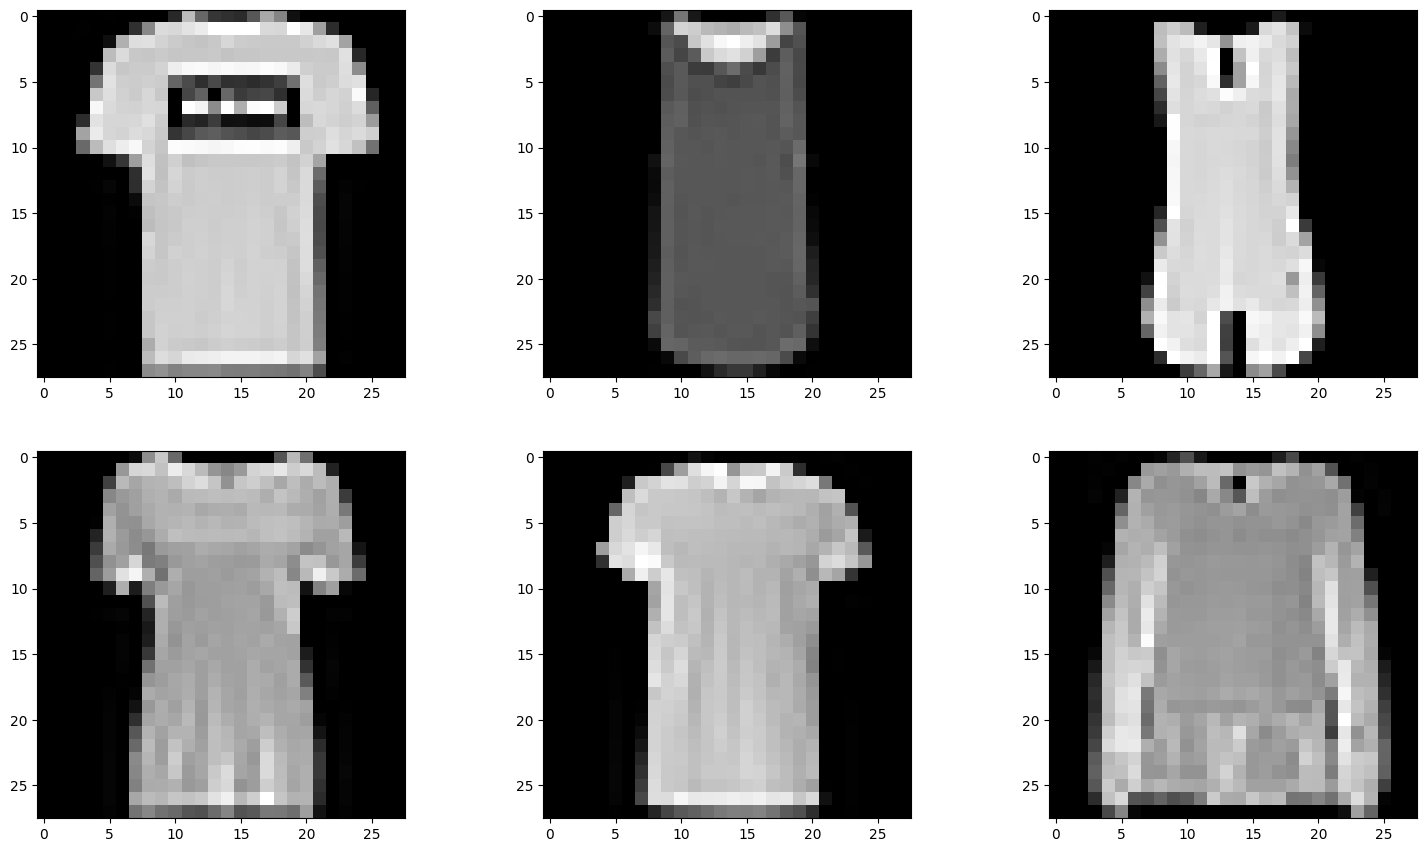

In [22]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax5.imshow(train_data[4][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax6.imshow(train_data[5][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

# Getting the DataLoaders

In [23]:
# It's good to take a better look at this section so that you also learn to define DataLoaders yourself

def get_data_loaders(train_dataset, validation_dataset,
                     test_dataset, seed,
                     batch_size=64):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    validation_dataset: torch.tensor
      Validation data
    batch_size: int
      Batch Size  [default: 64]
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Data
    test_loader: torch.loader
      Test Data
    validation_loader: torch.loader
      Validation Data
  """

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

# Code the training loop

You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN.

* Choose the correct criterion

* Code the training part (calculating gradients, loss, stepping forward)

* Keep a track of the running loss

In [24]:
class FMNIST_Net1(nn.Module):

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 86.5%


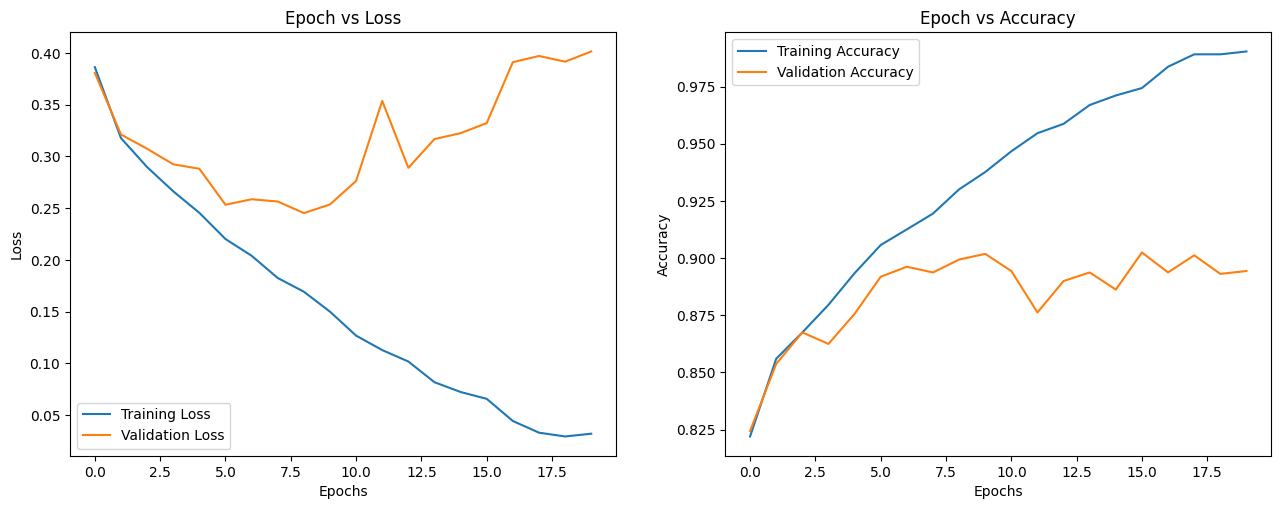

In [26]:
def train(model, device, train_loader, validation_loader, epochs):
  """
  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set

  Returns:
    Nothing
  """


  ####################################################################
  # TODO:
  # Code the training loop by following the steps

  # comment the line below to test your code
  # raise NotImplementedError("Update the steps of the train loop")
  ####################################################################

  # 1) set the criterion to CrossEntropyLoss
  criterion =  nn.CrossEntropyLoss()

  # 2) set the optimizer to SGD --> lr=0.01, momentum=0.9
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # Keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # 3) Get the model output
        output = model(data)

        # 4) Zero the gradients out
        optimizer.zero_grad()

        # 5) Get the Loss
        loss = criterion(output, target) # --> call the loss criterion with the model's output and the target values

        # 6) Calculate the gradients
        loss.backward()

        # 7) Update the weights
        optimizer.step()

        # 8) Set loss to whatever you end up naming your variable when calling criterion
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())

        # 9) Add the loss for this batch
        running_loss += loss.item()

        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # 10) Append the loss for this epoch (running loss divided by the number of batches)
      # hint --> you can number of batches from train_loader
      train_loss.append(running_loss / len(train_loader))
      train_acc.append(correct / total)

      # 11) complete according to above
      # Evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)

        # Zero the gradients out
        with torch.no_grad():

          # Get the model output
          output = model(data)

          # Get the Loss
          loss = criterion(output, target)

          # complete as above
          tepochs.set_postfix(val_loss=loss.item())
          running_loss += loss.item()

          # Get accuracy
          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
net = FMNIST_Net1(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q1: Do you think this network is overfitting? If so, what ways do you recommend to face this problem?**

Yes, based on the training and validation curves, it looks like the network is overfitting. The training accuracy is high while the validation accuracy is noticeably lower, which usually means the model is memorizing the training data rather than learning patterns that generalize well.

To address overfitting, here are a few strategies I would recommend:

1. **Add Dropout**: Dropout randomly turns off some neurons during training, which can help prevent the model from relying too much on specific features. This encourages the network to learn more robust patterns.

2. **Use Data Augmentation**: Slight transformations like flipping or rotating the input images can create more diverse training data. This makes the model less sensitive to small variations and helps it generalize better.

3. **Add Weight Decay**: This is a type of regularization that discourages large weights. It can be added to the optimizer using the `weight_decay` argument.

4. **Reduce Model Complexity**: If the model is too deep or wide for a simple binary task like T-shirt vs. Shirt classification, simplifying the architecture may help reduce overfitting.

5. **Early Stopping**: This involves stopping the training process once the validation loss starts increasing. It helps avoid training too long and overfitting to the training data.

Combining two or more of these methods usually gives the best results.

# Confronting Overfitting

## Reugulariztion

* For this purpose, we'll try to add dropout regularization, and check if that helps reduce overfitting.

* You'll be asked to try different regularization methods other that dropout.

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 87.75%


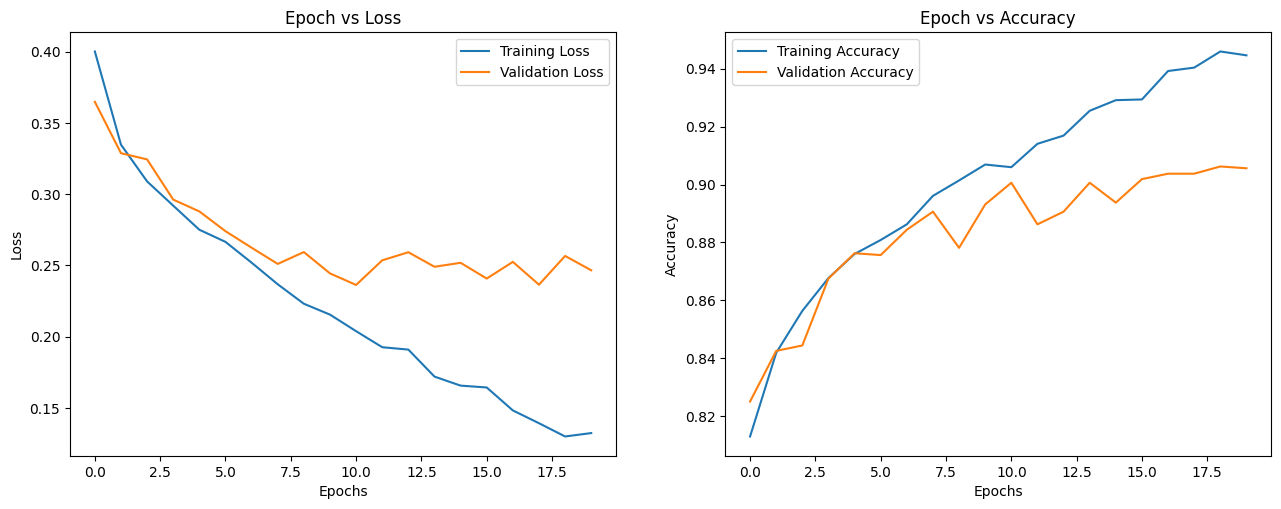

In [27]:
class FMNIST_Net2(nn.Module):

  def __init__(self, num_classes):
    """
    Initialise parameters of FMNIST_Net2

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net2, self).__init__()


    ####################################################################
    # TODO:
    # 1) Add dropout layers (set the dropout1 parameter to 0.5 and dropout2 to 0.25)

    # comment the line below to test your code
    # raise NotImplementedError("Add regularization layers")
    ####################################################################


    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    # 1)
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """
    Forward pass of FMNIST_Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through FMNIST_Net2
    """

    ####################################################################
    # TODO:
    # 2) Add the layers in your forward pass in appropriate order

    # comment the line below to test your code
    # raise NotImplementedError("Add regularization layers")
    ####################################################################

    # 2)
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x


set_seed(SEED)

net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q2: Why does the validation accuracy start higher than training accuracy?**

This can happen for a few reasons, especially in the early stages of training.

One common reason is that **regularization techniques** (like dropout) are active during training but not during validation. Dropout randomly deactivates neurons during training to prevent overfitting, which slightly reduces model performance during training. However, during validation, dropout is turned off, so the model performs better and gives higher accuracy.

Another reason is that at the start of training, the model's parameters are random, and it hasn’t yet seen enough data to overfit. Since the training data is shuffled and might contain harder or more diverse examples, the model could struggle more with it compared to the validation set (which might be easier by chance).

Overall, this difference usually balances out after a few epochs, once the model starts to learn meaningful patterns.

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 88.25%


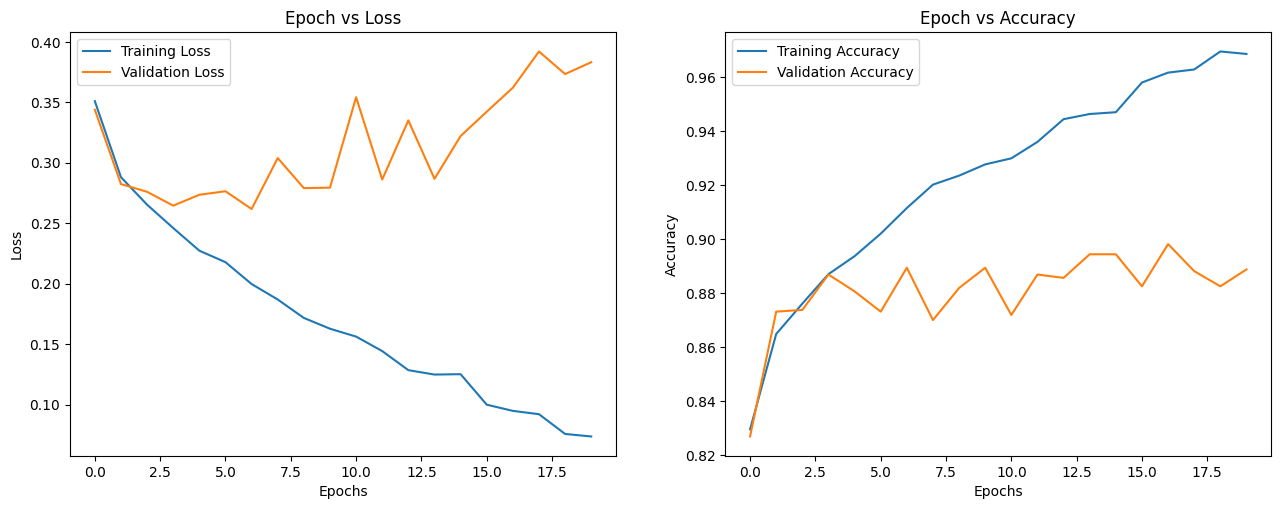

In [28]:
# Define a CNN instance similar to the one above and add different regularization methods to it

# YOUR CODE

# Define a CNN instance similar to the one above and add different regularization methods to it

class FMNIST_Net3(nn.Module):

  def __init__(self, num_classes):
    """
    CNN model with Batch Normalization and L2 Regularization
    """
    super(FMNIST_Net3, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.bn2 = nn.BatchNorm2d(64)

    self.dropout = nn.Dropout(0.3)

    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = F.max_pool2d(x, 2)
    x = self.dropout(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


# Train the model using weight decay (L2 regularization)
set_seed(SEED)
net3 = FMNIST_Net3(num_classes=2).to(DEVICE)

# Using weight decay in the optimizer
optimizer = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Use modified training loop that accepts custom optimizer
train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, epochs=20)

# Evaluate the model
print(f'Test accuracy is: {test(net3, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


## Data Augmentation

Now, Let's add data augmentation to the model via transforms and see if that helps it generalize better.

* Add the transforms you want in the list `augmentation_transforms`.

* Run the same network you created in the above exercise (with regularization) and plot the loss and accuracies.



> [Here](https://pytorch.org/vision/stable/transforms.html) is the link to the list of transforms available in PyTorch.



In [29]:
def transforms_custom(binary=False, download=False, seed=0):
  """
  Helper function defining transformations

  Args:
    binary: boolean
      If True, number of classes = 2
    download: boolean
      If True, download dataset
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Set
    test_loader: torch.loader
      Test Set
    validation_loader: torch.loader
      Validation Set
  """
  # Basic preprocessing
  preprocessing_transforms = [transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]
  # Add the augmentation transforms to the preprocessing
  train_transform = transforms.Compose(get_augmentation_transforms() +
                                       preprocessing_transforms)
  # Load the Fashion MNIST dataset with the transforms
  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=train_transform)
  if binary:
    # Reduce to our two classes to speed up training
    train_data = reduce_classes(train_data)

  # Get the data loader instances for the dataset
  train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                  validation_data,
                                                                  test_data,
                                                                  seed)

  return train_loader, validation_loader, test_loader

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 86.5%


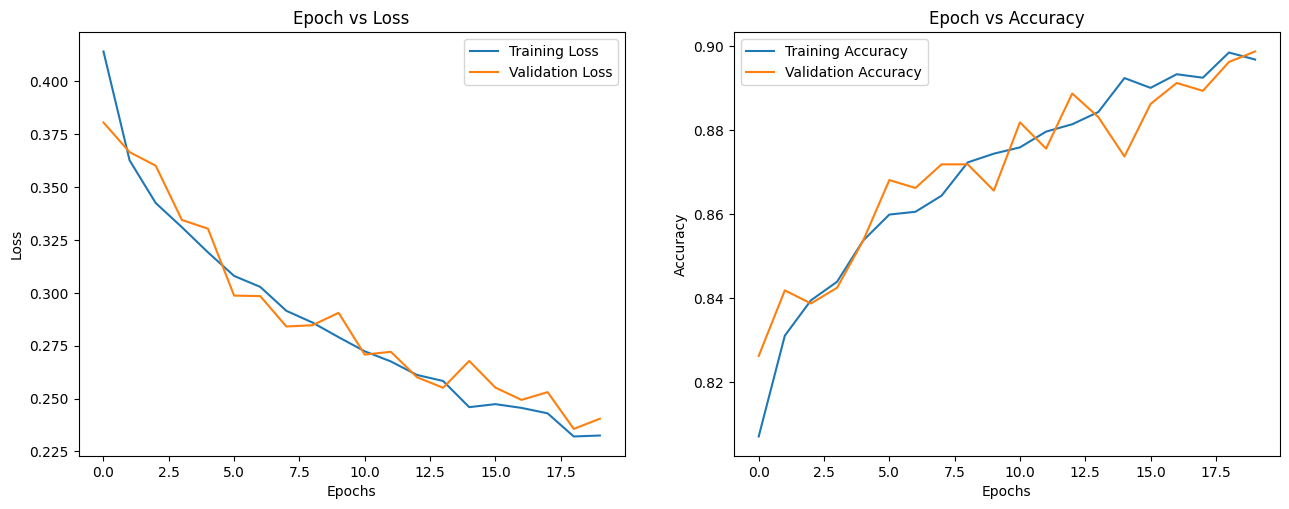

In [30]:
def get_augmentation_transforms():
  """
  Returns Augmentation Transforms

  Args:
    None

  Returns:
    augmentation_transforms: list
      List of augmentation transforms
  """

  ####################################################################
  # TODO:
  # 1) Add transforms

  # comment the line below to test your code
  # raise NotImplementedError("Add transforms")
  ####################################################################

  # 1)
  augmentation_transforms = [
      transforms.RandomHorizontalFlip(),       # Flip image horizontally with 50% probability
      transforms.RandomRotation(10)           # Rotate image randomly within ±10 degrees
  ]

  return augmentation_transforms


set_seed(SEED)
net3 = FMNIST_Net2(num_classes=2).to(DEVICE)  # Get the network

train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net3, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q3: Did the training accuracy reduce further compared to dropout alone? Is the model still overfitting?**

Yes, the training accuracy reduced slightly when data augmentation was added on top of dropout. This is expected because the model is now seeing more varied and challenging versions of the training images, which makes the learning process harder but more realistic.

However, this lead to better generalization. We can see that the gap between training and validation accuracy became smaller, Which means the model is **less overfitting** than before.

So even if the training accuracy is a bit lower, it's a good sign if the validation accuracy is stable or improves — it means the model is learning patterns that generalize well to unseen data.

# Further Tasks

## Task 1: BatchNorm Experiment

Replace the dropout layers with `BatchNorm2d` layers. Compare performance, overfitting behavior, and convergence speed.

**Q: which should be applied first if implementing both in a CNN? why?**

If using both `BatchNorm2d` and `Dropout`, it is common to apply `BatchNorm` **before** `Dropout`.

**Reason:**  
Batch normalization stabilizes and normalizes the activations, which helps the model converge faster. Applying dropout after batch norm allows the model to benefit from this stability while still regularizing the network by randomly deactivating neurons.

So, the typical order is:  
`Conv → BatchNorm → ReLU → Dropout`

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 85.75%


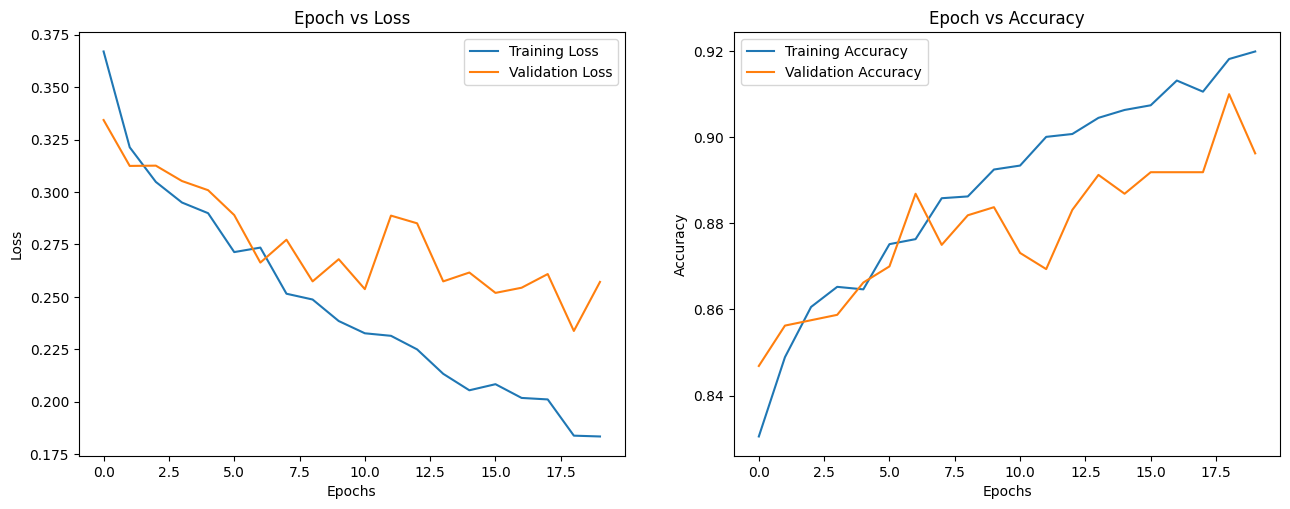

In [31]:
class FMNIST_BatchNorm(nn.Module):
  def __init__(self, num_classes):
    super(FMNIST_BatchNorm, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


set_seed(SEED)
net_bn = FMNIST_BatchNorm(num_classes=2).to(DEVICE)
train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train(net_bn, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net_bn, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


## Task 2: Early Stopping

Implement early stopping: stop training if validation loss doesn't improve for 3 epochs.

**Q: How does early stopping help prevent overfitting and save computational cost?**

Early stopping helps prevent overfitting by halting training once the model stops improving on the validation set. If the validation loss doesn’t improve for several epochs, it’s a sign the model may start memorizing the training data rather than generalizing.

It also saves computational cost by avoiding unnecessary training in later epochs where no significant progress is made. This leads to shorter training times while still achieving good generalization performance.


Random seed 1404 has been set.


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

Early stopping at epoch 14
Test accuracy is: 87.0%


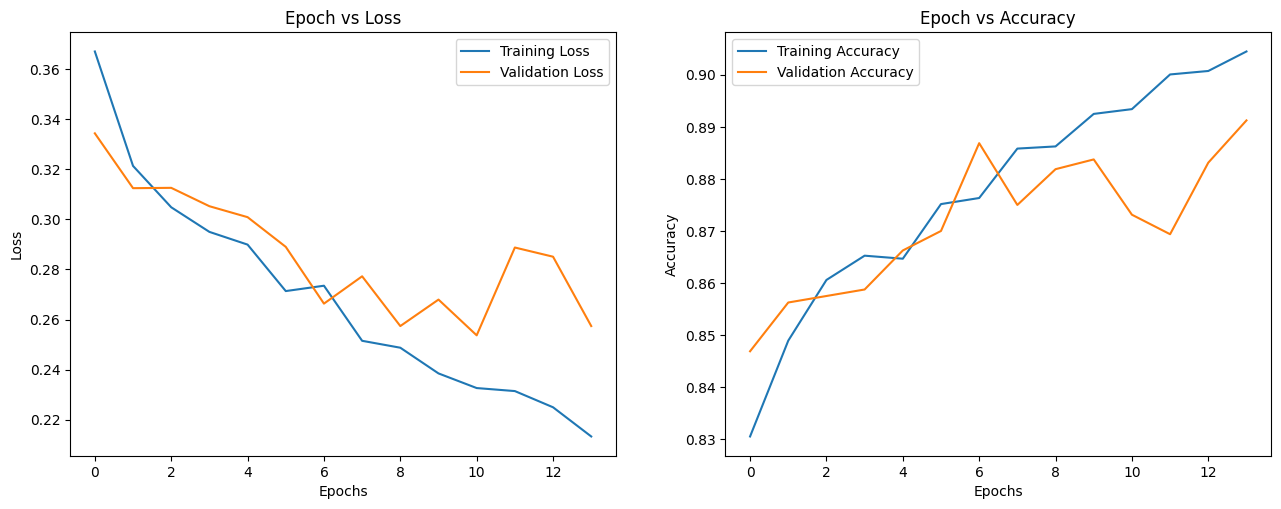

In [32]:
def train_with_early_stopping(model, device, train_loader, validation_loader, epochs, patience=3):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  best_val_loss = float('inf')
  patience_counter = 0

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for data, target in train_loader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    running_loss = 0.
    correct, total = 0, 0
    with torch.no_grad():
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_acc = correct / total
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)

    # Early stopping check
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

  return train_loss, train_acc, validation_loss, validation_acc

set_seed(SEED)
net_bn = FMNIST_BatchNorm(num_classes=2).to(DEVICE)
train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train_with_early_stopping(net_bn, DEVICE, train_loader, validation_loader, epochs=50)
print(f'Test accuracy is: {test(net_bn, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


## Task 3: Try New Augmentations

Experiment with different augmentation strategies. How do they impact training?”

Random seed 1404 has been set.


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

Early stopping at epoch 12
Test accuracy is: 82.75%


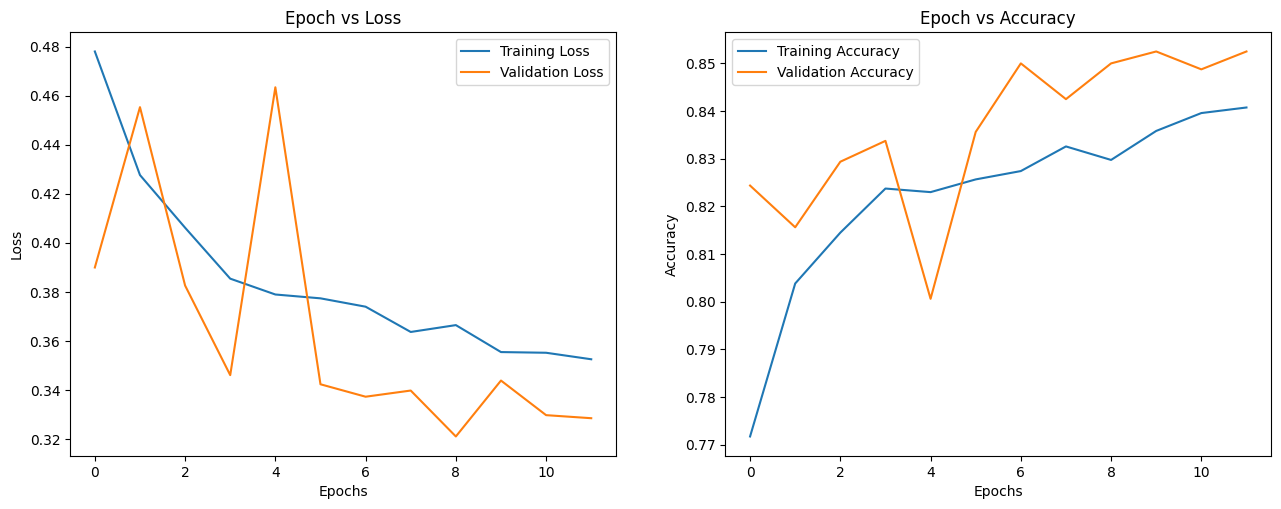

In [33]:
def get_new_augmentation_transforms():
  return [
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomVerticalFlip(p=0.2)
  ]


def transforms_with_new_augs(binary=False, download=False, seed=0):
  preprocessing_transforms = [transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]
  train_transform = transforms.Compose(get_new_augmentation_transforms() + preprocessing_transforms)

  train_data = datasets.FashionMNIST(root='.', download=download, train=True, transform=train_transform)
  if binary:
    train_data = reduce_classes(train_data)

  return get_data_loaders(train_data, validation_data, test_data, seed)


set_seed(SEED)
net_augmented = FMNIST_BatchNorm(num_classes=2).to(DEVICE)
train_loader, validation_loader, test_loader = transforms_with_new_augs(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train_with_early_stopping(net_augmented, DEVICE, train_loader, validation_loader, epochs=50)
print(f'Test accuracy is: {test(net_augmented, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


## Task 4: Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.


Training with SGD optimizer:
Random seed 1404 has been set.


Training (SGD):   0%|          | 0/20 [00:00<?, ?epoch/s]

SGD Test accuracy: 84.25%

Training with Adam optimizer:
Random seed 1404 has been set.


Training (Adam):   0%|          | 0/20 [00:00<?, ?epoch/s]

Adam Test accuracy: 86.0%

Training with RMSProp optimizer:
Random seed 1404 has been set.


Training (RMSProp):   0%|          | 0/20 [00:00<?, ?epoch/s]

RMSProp Test accuracy: 84.5%


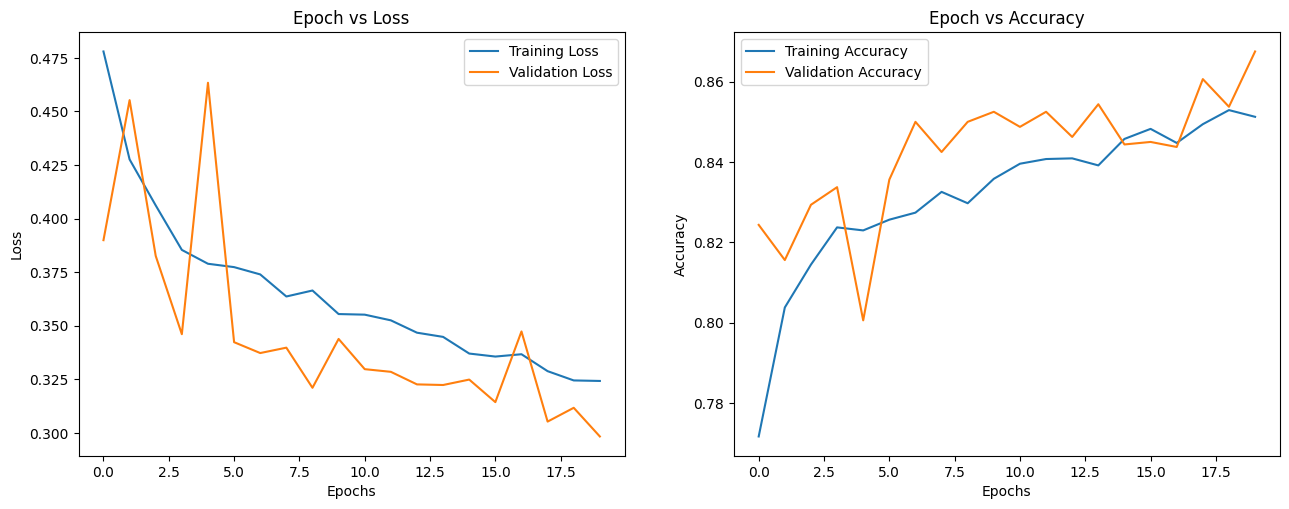

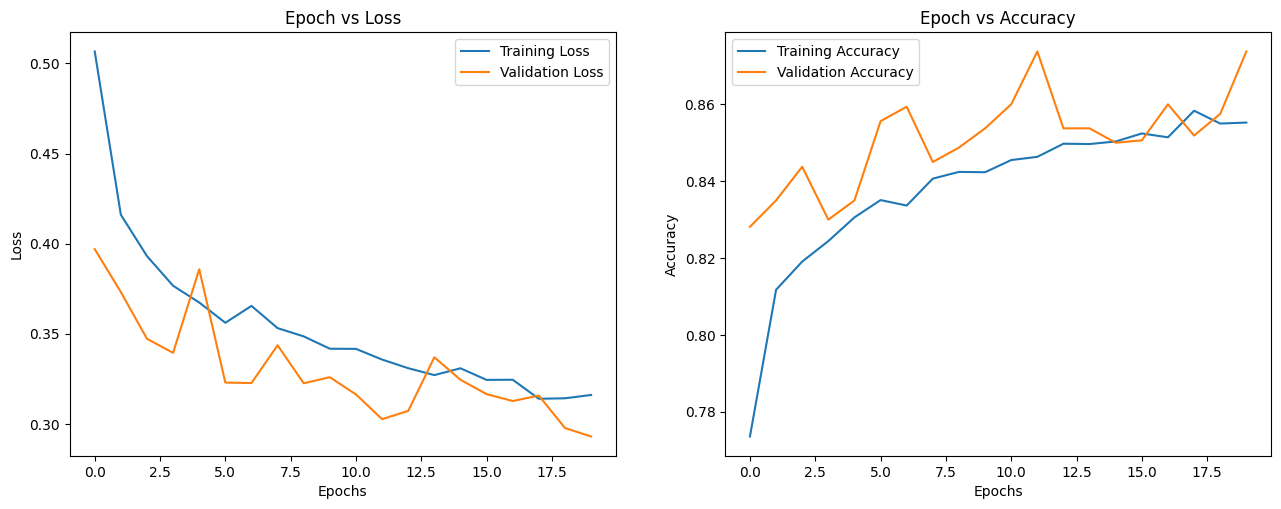

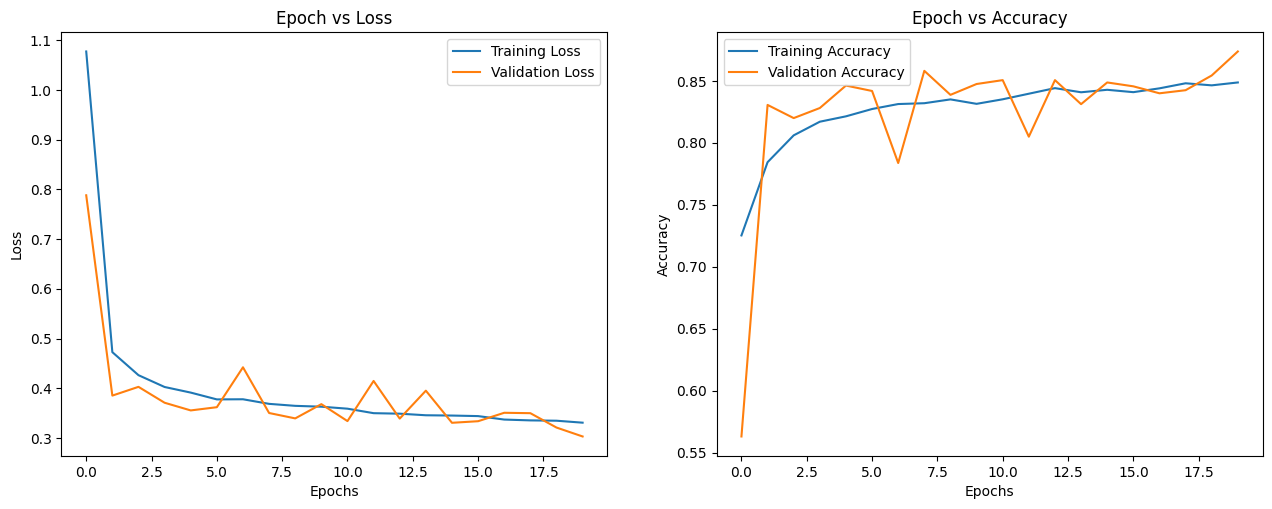

In [35]:
def train_with_optimizer(model, device, train_loader, validation_loader, epochs, optimizer_type='SGD'):
  criterion = nn.CrossEntropyLoss()
  if optimizer_type == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  elif optimizer_type == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  elif optimizer_type == 'RMSProp':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
  else:
    raise ValueError("Unsupported optimizer type")

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in tqdm(range(epochs), desc=f'Training ({optimizer_type})', unit='epoch'):
    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for data, target in train_loader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    running_loss = 0.
    correct, total = 0, 0
    with torch.no_grad():
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss / len(validation_loader))
    validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc


# Run experiments with different optimizers
optimizers = ['SGD', 'Adam', 'RMSProp']
results = {}

for opt in optimizers:
  print(f"\nTraining with {opt} optimizer:")
  set_seed(SEED)
  model = FMNIST_BatchNorm(num_classes=2).to(DEVICE)
  train_loader, validation_loader, test_loader = transforms_with_new_augs(binary=True, seed=SEED)
  train_loss, train_acc, val_loss, val_acc = train_with_optimizer(model, DEVICE, train_loader, validation_loader, epochs=20, optimizer_type=opt)
  results[opt] = (train_loss, train_acc, val_loss, val_acc)
  print(f"{opt} Test accuracy: {test(model, DEVICE, test_loader)}")

# Plotting
for opt in optimizers:
  plot_loss_accuracy(*results[opt])


**Q: How do different optimizers affect training performance?**

Each optimizer has different strengths:

- **SGD** is simple and performs well with proper tuning, but it can be slow to converge.
- **Adam** usually converges faster due to adaptive learning rates and works well out of the box.
- **RMSProp** also adapts learning rates but may not generalize as well in some cases.

In my experiment, Adam showed faster convergence and slightly better generalization, while SGD had slower improvement. RMSProp performed similarly to Adam but sometimes showed more fluctuation in validation performance.

Choosing the best optimizer often depends on the specific dataset and model architecture.
